<a href="https://colab.research.google.com/github/AishwaryaAshok846/Heart-Disease-Prediction/blob/main/heart_disease_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Heart Disease Prediction Using Machine Learning

### Project Overview

Cardiovascular diseases (CVDs) are the leading cause of death globally, accounting for approximately 31% of all deaths worldwide. Early detection of heart disease is crucial, as many cases can be managed or prevented through timely medical intervention.

In this project, we analyze a heart disease dataset containing clinical and demographic information of patients. The goal is to build and evaluate machine learning models that can predict whether a patient is likely to have heart disease based on these features.

This notebook follows a structured data science workflow:
- Data loading and inspection  
- Exploratory Data Analysis (EDA)  
- Data preprocessing  
- Model training and evaluation  
- Model comparison and insights  

This project is for educational purposes only and does not serve as a medical diagnosis tool.


## Dataset Description

This dataset was obtained from Kaggle and was originally compiled by combining
multiple heart disease datasets from the UCI Machine Learning Repository.

It contains clinical and demographic features that are commonly used in heart
disease risk assessment, along with a binary target variable indicating the
presence or absence of heart disease.


In [4]:
# Core libraries
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    RocCurveDisplay
)

# Style
# sns.set(style="whitegrid")


## Data Loading

Loading the heart disease dataset and exploring its structure, size, and basic characteristics.

In [5]:
df = pd.read_csv('/content/heart.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [7]:
# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

#check for duplicate values
print("\nDuplicate values: ")
print(df.duplicated().sum())

Missing values per column:
Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

Duplicate values: 
0


### Dataset Summary

- The dataset contains **918 patient records** and **12 columns**
- There are **no missing values** in any feature
- Features include both **numerical** and **categorical** variables
- The target variable is **HeartDisease** which is in binary
- No duplicate rows exist in the database


## Target Variable distribution:
Examining the distribution of heart disease cases in the dataset to check for class balance.

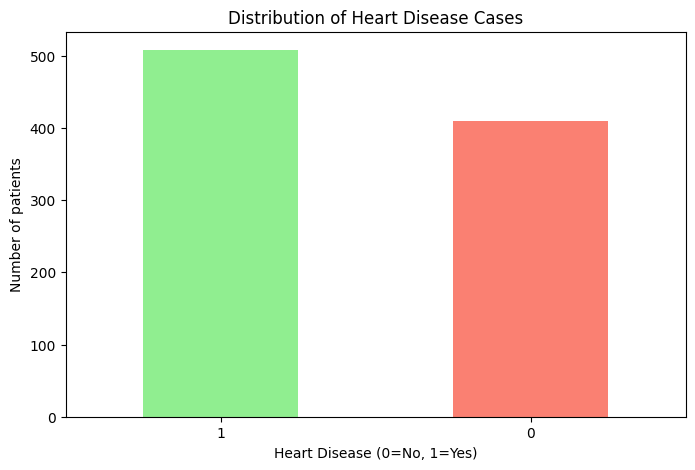


Percentage with heart disease: 55.3%


In [8]:
# Distribution of target variable (heart disease presence)
target = df['HeartDisease'].value_counts()

plt.figure(figsize=(8, 5))
target.plot(kind='bar', color=['lightgreen', 'salmon'])
plt.title('Distribution of Heart Disease Cases')
plt.xlabel('Heart Disease (0=No, 1=Yes)')
plt.ylabel('Number of patients')
plt.xticks(rotation=0)
plt.show()

disease_count = target[1]
total_patients = len(df)

disease_perc = (disease_count / total_patients) * 100
disease_perc = round(disease_perc, 1)

print(f"\nPercentage with heart disease: {disease_perc}%")

**Analysis:**  
The dataset shows that 55.3% of patients have heart disease while 44.7% are healthy. This relatively balanced distribution is favorable for training machine learning models without significant class imbalance issues.

### Correlation Analysis

A correlation heatmap to help identify which features are most strongly associated with heart disease and how features relate to each other. Positive correlations appear in red, negative correlations in blue.


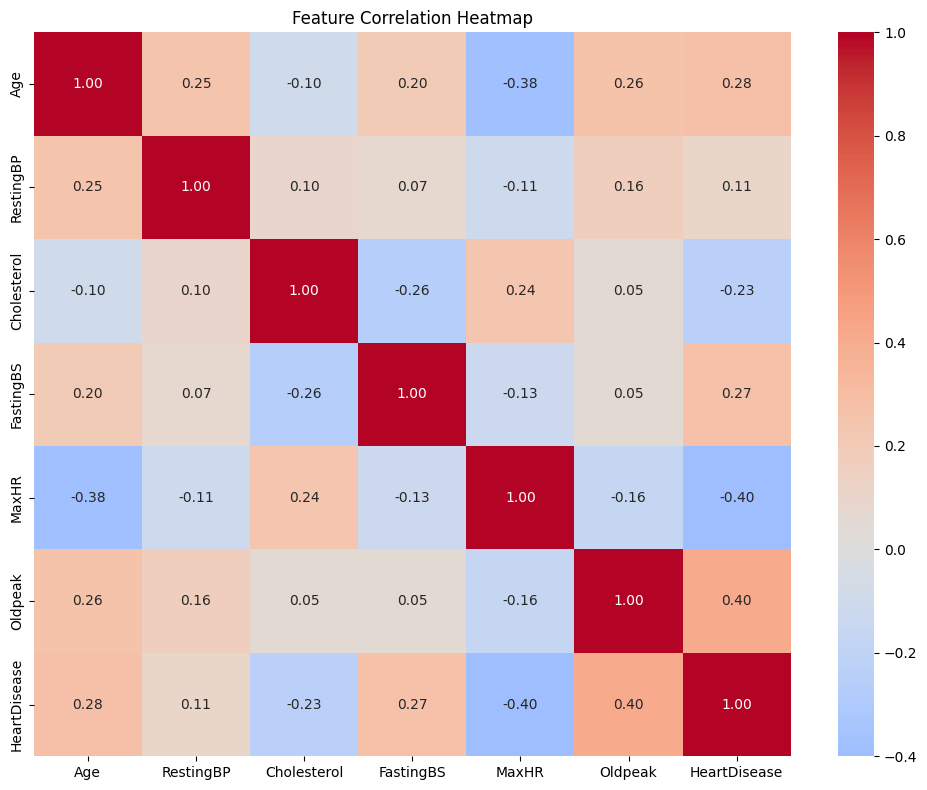

In [9]:
# Calculate correlation matrix for numeric columns only
corr_matrix = df.corr(numeric_only=True)

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

In [10]:
# Show correlations with HeartDisease
target_corr = corr_matrix['HeartDisease'].sort_values(ascending=False)

print("Features most correlated with heart disease:")
print(target_corr)

Features most correlated with heart disease:
HeartDisease    1.000000
Oldpeak         0.403951
Age             0.282039
FastingBS       0.267291
RestingBP       0.107589
Cholesterol    -0.232741
MaxHR          -0.400421
Name: HeartDisease, dtype: float64


**Analysis:**  
Oldpeak (0.40) shows the strongest positive correlation with heart disease, followed by Age (0.28) and FastingBS (0.27). MaxHR (-0.40) shows a strong negative correlation, indicating that patients with lower maximum heart rates are more likely to have heart disease. Cholesterol (-0.23) also shows negative correlation. These correlations suggest that Oldpeak, age, blood sugar levels, and cardiovascular fitness (MaxHR) are important predictors of heart disease.

### Distribution of Continuous Features by Disease Status

Box plots to visualize how continuous features differ between patients with and without heart disease. This will reveal which features show distinct patterns that could be useful for prediction.

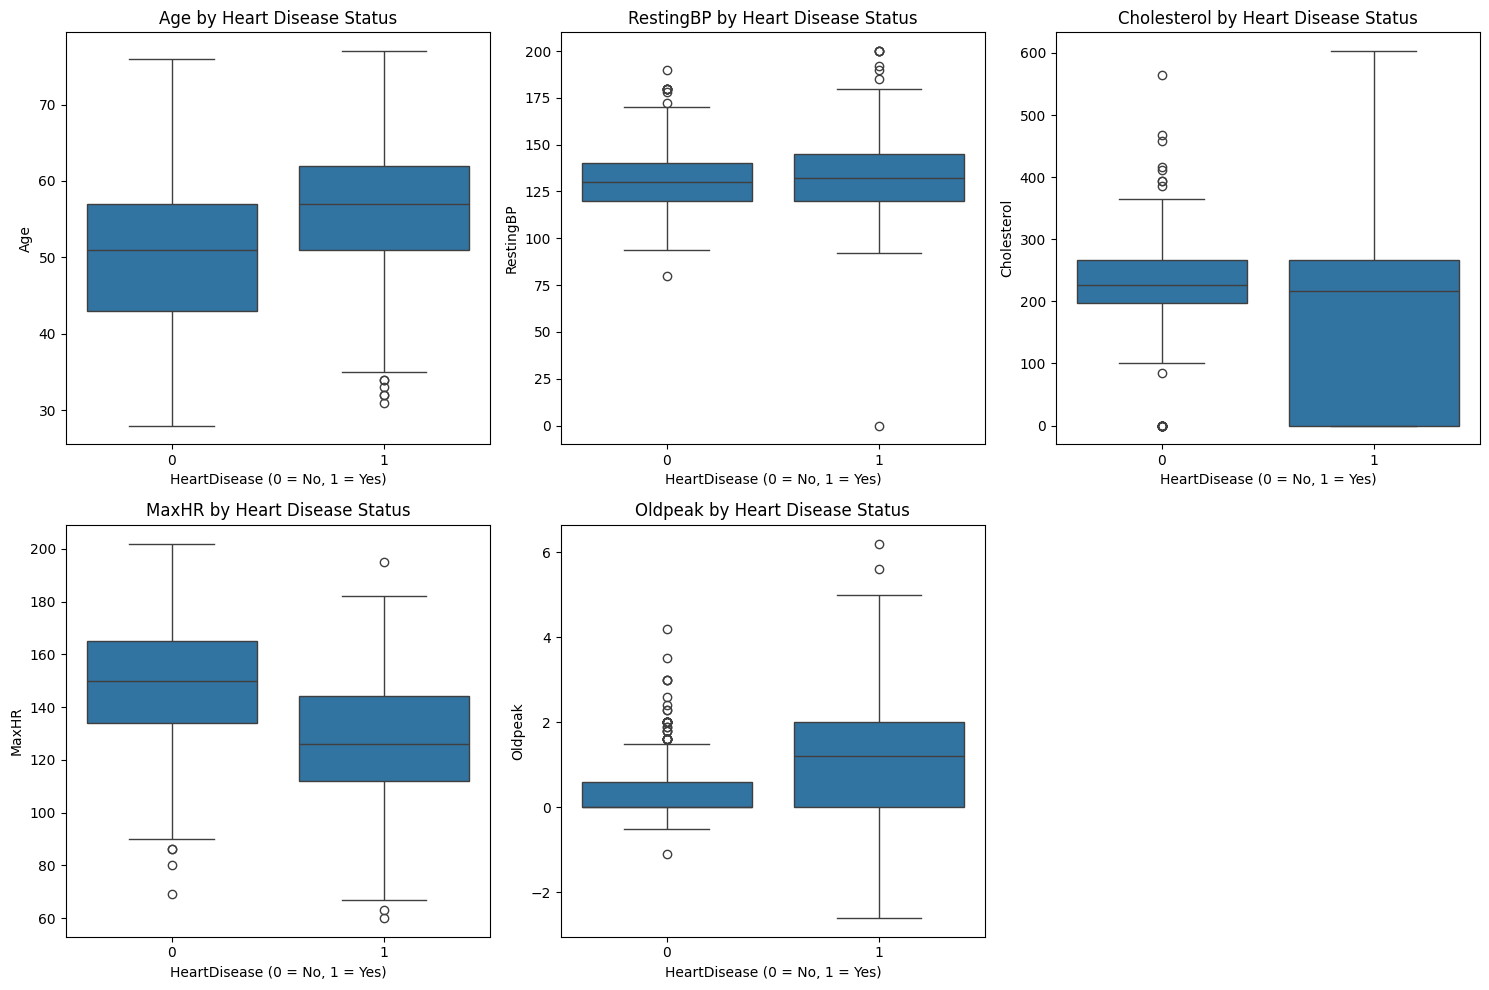

In [11]:
# Create figure for multiple box plots
plt.figure(figsize=(15, 10))

# List of continuous features to analyze
continuous_features = ["Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak"]

# Create box plot for each feature
for i, feature in enumerate(continuous_features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x="HeartDisease", y=feature, data=df)
    plt.title(f"{feature} by Heart Disease Status")
    plt.xlabel("HeartDisease (0 = No, 1 = Yes)")
    plt.ylabel(feature)

# Adjust spacing between plots
plt.tight_layout()
plt.show()

**Analysis:**  
MaxHR shows the clearest separation between groups, with heart disease patients having lower maximum heart rates compared to healthy patients. Oldpeak also displays distinct differences, with diseased patients showing higher values. Age shows moderate differences, with heart disease patients tending to be slightly older. RestingBP shows minimal distinction between the two groups.

**Data Quality Issue:** Cholesterol displays an unusual pattern containing many zero values, which are impossible and likely represent missing data. This will be addressed in the preprocessing stage

### Feature Distributions

Examining the distribution of key continuous features to understand their patterns and identify any skewness or anomalies.

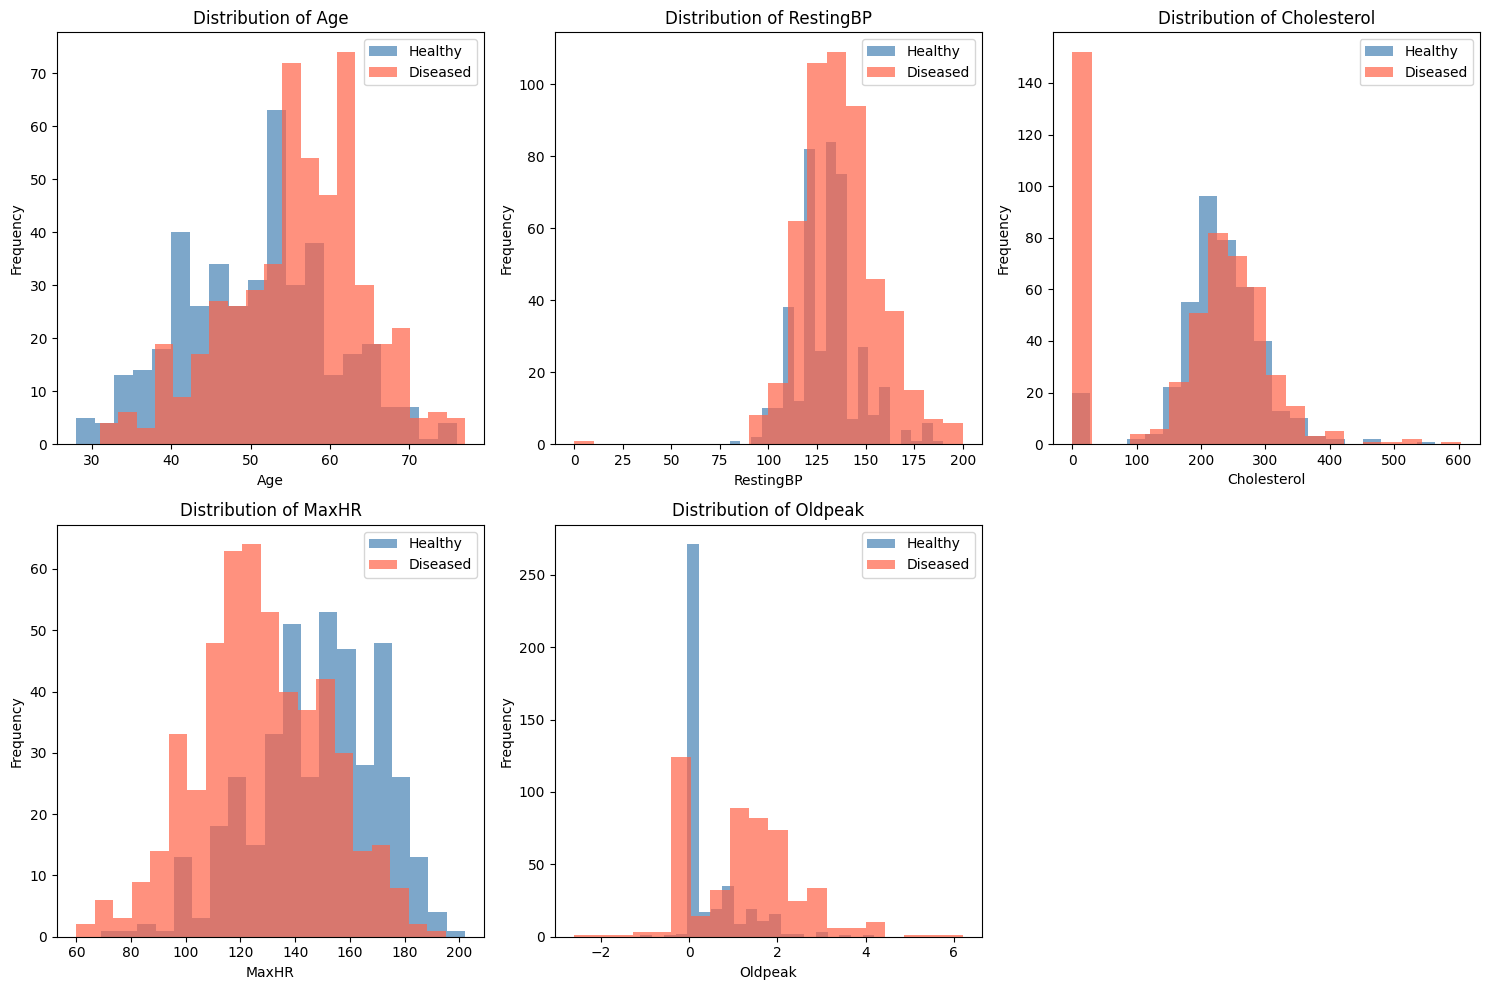

In [12]:
# Compare distributions between diseased and healthy patients
plt.figure(figsize=(15, 10))

continuous_features = ["Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak"]

# Plot overlapping histograms for each feature
for i, feature in enumerate(continuous_features, 1):
    plt.subplot(2, 3, i)

    # Healthy patients
    healthy = df[df['HeartDisease'] == 0][feature]
    # Diseased patients
    diseased = df[df['HeartDisease'] == 1][feature]

    plt.hist(healthy, bins=20, alpha=0.7, label='Healthy', color='steelblue')
    plt.hist(diseased, bins=20, alpha=0.7, label='Diseased', color='tomato')

    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.legend()

plt.tight_layout()
plt.show()

**Analysis:**  
Age shows that diseased patients are mostly between 50-65 years old, while healthy patients have a wider age range. RestingBP displays significant overlap between both groups with similar distributions, indicating limited predictive value

Cholesterol confirms the earlier identified data quality issue, with a large spike at zero in both groups representing missing data.

MaxHR shows clear separation, with healthy patients having higher heart rates (140-200) compared to diseased patients (100-140).

Oldpeak displays the strongest distinction, with healthy patients concentrated near zero while diseased patients show higher and more varied values.

### Categorical Features Analysis

Examining how categorical features relate to heart disease presence to identify patterns in non numeric variables.

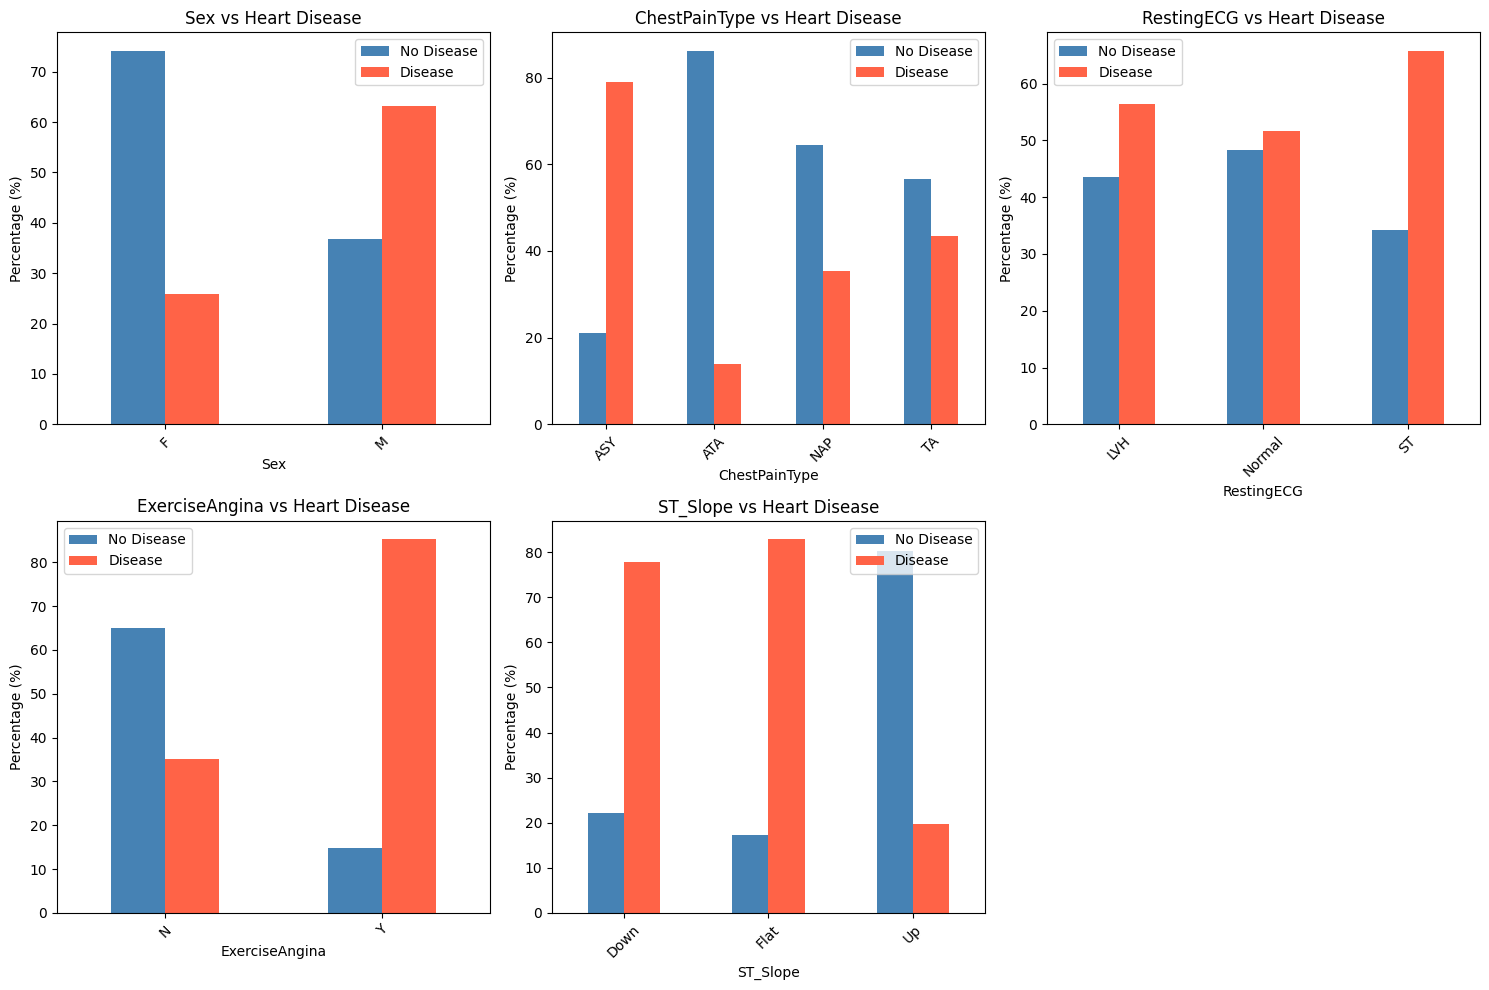

In [13]:
# List of categorical features
categorical_features = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

# Create the figure
plt.figure(figsize=(15, 10))

# Loop through each categorical feature
for i, feature in enumerate(categorical_features, 1):

    # Create subplot
    plt.subplot(2, 3, i)

    # Calculate percentage of heart disease within each category
    proportions = pd.crosstab(df[feature], df['HeartDisease'], normalize='index') * 100

    # Plot bar chart
    proportions.plot(kind='bar', color=['steelblue', 'tomato'], ax=plt.gca()   # plot on current subplot
    )

    # Add titles and labels
    plt.title(f'{feature} vs Heart Disease')
    plt.xlabel(feature)
    plt.ylabel('Percentage (%)')
    plt.legend(['No Disease', 'Disease'])
    plt.xticks(rotation=45)

# Adjust spacing so plots don’t overlap
plt.tight_layout()
plt.show()


**Analysis**

Clear differences appear when comparing proportions across categories. Male
patients show a higher percentage of heart disease compared to females. Chest pain type shows strong variation, with asymptomatic cases having the highest disease proportion, while atypical angina has the lowest.

Exercise induced angina is strongly associated with heart disease, as a large
majority of patients experiencing it fall into the diseased group. ST slope also shows a clear pattern, with flat and downward slopes having much
higher disease proportions compared to upward slopes.

Resting ECG categories show some variation, but the differences are less
pronounced compared to other categorical features.


## Data Preprocessing

Preparing the data for machine learning by handling missing values, splitting into training and testing sets, and scaling features for optimal model performance.

### Handling Missing Data

Cholesterol values of zero are impossible and represent missing data. These will be replaced with the median cholesterol value to preserve the dataset size while providing reasonable estimates.

In [15]:
# Check how many zero cholesterol values
zero_count = (df['Cholesterol'] == 0).sum()
print(f"Zero cholesterol values: {zero_count}")

# Calculate median of non-zero values
non_zero_chol = df[df['Cholesterol'] > 0]
median_value = non_zero_chol['Cholesterol'].median()

# Replace zeros with median
df['Cholesterol'] = df['Cholesterol'].replace(0, median_value)

print(f"Replaced with median: {median_value}")
print(f"Zeros remaining: {(df['Cholesterol'] == 0).sum()}")

Zero cholesterol values: 172
Replaced with median: 237.0
Zeros remaining: 0


**Analysis:**  
172 zero cholesterol values were identified and replaced with the median value of 237. This approach preserves the dataset size while providing reasonable estimates for missing measurements.

### Encoding Categorical Variables

Categorical features are converted to numeric format using encoding techniques to be understood by the machine learning model.

In [19]:
# Check current data types
print("Data types before encoding:")
print(df.dtypes)

# Check unique values in categorical columns
categorical = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

print("\nUnique values in each categorical column:")
for col in categorical:
    print(f"\n{col}: {df[col].unique()}")

Data types before encoding:
Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

Unique values in each categorical column:

Sex: ['M' 'F']

ChestPainType: ['ATA' 'NAP' 'ASY' 'TA']

RestingECG: ['Normal' 'ST' 'LVH']

ExerciseAngina: ['N' 'Y']

ST_Slope: ['Up' 'Flat' 'Down']


In [20]:
from sklearn.preprocessing import LabelEncoder

# Create label encoder
le = LabelEncoder()

# Encode each categorical column
for col in categorical:
    df[col] = le.fit_transform(df[col])


print("\nData types after encoding:")
print(df.dtypes)

#  first few rows to verify
print("\nFirst few rows after encoding:")
print(df.head())


Data types after encoding:
Age                 int64
Sex                 int64
ChestPainType       int64
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG          int64
MaxHR               int64
ExerciseAngina      int64
Oldpeak           float64
ST_Slope            int64
HeartDisease        int64
dtype: object

First few rows after encoding:
   Age  Sex  ChestPainType  RestingBP  Cholesterol  FastingBS  RestingECG  \
0   40    1              1        140          289          0           1   
1   49    0              2        160          180          0           1   
2   37    1              1        130          283          0           2   
3   48    0              0        138          214          0           1   
4   54    1              2        150          195          0           1   

   MaxHR  ExerciseAngina  Oldpeak  ST_Slope  HeartDisease  
0    172               0      0.0         2             0  
1    156               0      1

### Separating Features and Target Variable

Splitting the dataset into input features (X) and target variable (y) for model training.

In [21]:
# Separate features and target
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeature columns: {list(X.columns)}")

Features shape: (918, 11)
Target shape: (918,)

Feature columns: ['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope']


### Train-Test Split

Splitting the data into training (80%) and testing (20%) sets to evaluate model performance on unseen data.

In [22]:
from sklearn.model_selection import train_test_split

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"\nTraining set disease distribution:")
print(y_train.value_counts())

Training set size: (734, 11)
Test set size: (184, 11)

Training set disease distribution:
HeartDisease
1    401
0    333
Name: count, dtype: int64


**Analysis:**  
The dataset has been split into 734 training samples and 184 test samples. The training set maintains a relatively balanced distribution with 401 diseased and 333 healthy cases, which will help prevent bias during model training

### Feature Scaling

Standardizing features to have mean=0 and standard deviation=1 to ensures all features contribute equally to model training

In [23]:
from sklearn.preprocessing import StandardScaler

# Create scaler
scaler = StandardScaler()

# Fit on training data and transform both sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training data shape: {X_train_scaled.shape}")
print(f"Test data shape: {X_test_scaled.shape}")

Training data shape: (734, 11)
Test data shape: (184, 11)


**Analysis:**  
All features have been standardized to have comparable scales. This is to ensure each feature contributes equally to predictions.

## Model Training and Evaluation

Training multiple machine learning models to predict heart disease and comparing their performance.

### Logistic Regression

Starting with logistic regression as a baseline due to its simplicity and easier interpretation.

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Train logistic regression model
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train_scaled, y_train)

# Make predictions
y_pred_lr = log_reg.predict(X_test_scaled)

# Calculate accuracy
accuracy_lr = accuracy_score(y_test, y_pred_lr)

accuracy_pct = round(accuracy_lr * 100, 2)
print(f"Logistic Regression Accuracy: {accuracy_pct}%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))

Logistic Regression Accuracy: 85.33%

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.88      0.83        77
           1       0.91      0.83      0.87       107

    accuracy                           0.85       184
   macro avg       0.85      0.86      0.85       184
weighted avg       0.86      0.85      0.85       184



**Analysis:**  

Logistic Regression achieves 85.3% accuracy on the test set. When the model predicts disease, it's correct 91% of the time. However, it only identifies 83% of actual disease cases, meaning some diseased patients are missed. This is an important limitation for medical applications.

### Random Forest Classifier

Training a Random Forest model to capture non-linear relationships and feature interactions that logistic regression might miss.

In [28]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test_scaled)

# Calculate accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
accuracy_rf_pct = round(accuracy_rf * 100, 2)

print(f"Random Forest Accuracy: {accuracy_rf_pct}%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 88.59%

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.88      0.87        77
           1       0.91      0.89      0.90       107

    accuracy                           0.89       184
   macro avg       0.88      0.89      0.88       184
weighted avg       0.89      0.89      0.89       184



**Analysis:**  
Random Forest achieves 88.6% accuracy, outperforming Logistic Regression by 3.3%. The model shows improved recall at 89%, meaning it catches more disease cases while maintaining high precision at 91%. This suggests Random Forest better captures complex patterns in the data compared to the linear model.

### XGBoost Classifier

Training XGBoost, an advanced gradient boosting algorithm known for high performance on structured data.

In [29]:
import xgboost as xgb

# Train XGBoost model
xgb_model = xgb.XGBClassifier(random_state=42, eval_metric='logloss')
xgb_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Calculate accuracy
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
accuracy_xgb_pct = round(accuracy_xgb * 100, 2)

print(f"XGBoost Accuracy: {accuracy_xgb_pct}%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))

XGBoost Accuracy: 84.78%

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.88      0.83        77
           1       0.91      0.82      0.86       107

    accuracy                           0.85       184
   macro avg       0.84      0.85      0.85       184
weighted avg       0.85      0.85      0.85       184



**Analysis:**  
XGBoost achieves 84.8% accuracy, slightly lower than both Logistic Regression and Random Forest. With 82% recall, it misses more disease cases compared to Random Forest. This suggests that for this particular dataset, the simpler Random Forest model is more effective, possibly due to the relatively small dataset size where XGBoost's complexity doesn't provide additional benefit.

### Model Comparison

Comparing all three models to identify the best performer for heart disease prediction.

In [30]:
# comparison table
models_comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost'],
    'Accuracy': [accuracy_lr, accuracy_rf, accuracy_xgb]
})

# Sort by accuracy
models_comparison = models_comparison.sort_values('Accuracy', ascending=False)

print(models_comparison)
print(f"\nBest Model: {models_comparison.iloc[0]['Model']}")

                 Model  Accuracy
1        Random Forest  0.885870
0  Logistic Regression  0.853261
2              XGBoost  0.847826

Best Model: Random Forest


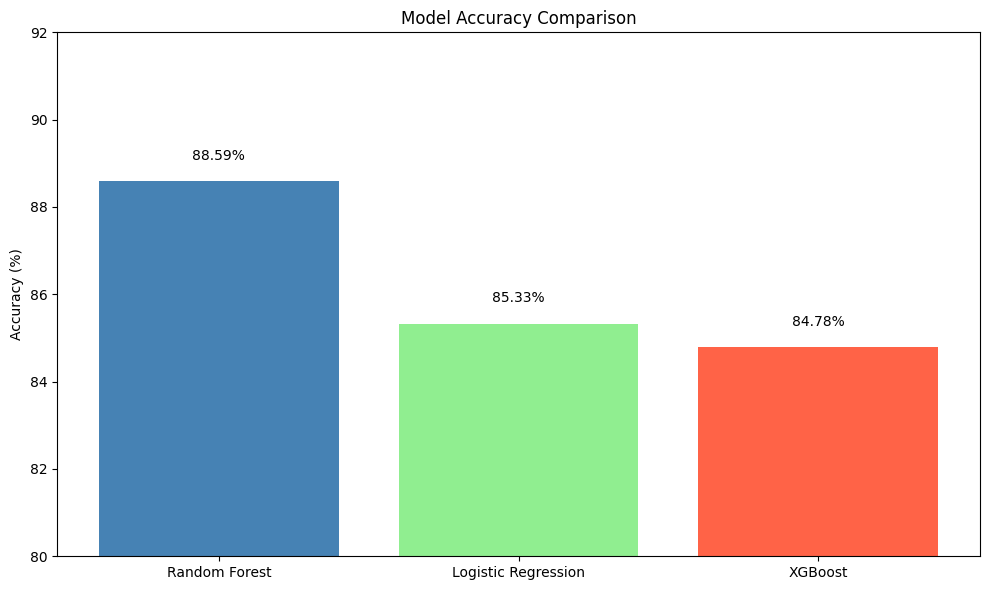

In [32]:
# Visualize model comparison
plt.figure(figsize=(10, 6))

models = models_comparison['Model']
accuracies = models_comparison['Accuracy'] * 100

plt.bar(models, accuracies, color=['steelblue', 'lightgreen', 'tomato'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy (%)')
plt.ylim([80, 92])

# accuracy values on top of bars
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.5, f'{v:.2f}%', ha='center')

plt.tight_layout()
plt.show()

**Analysis:**  
Random Forest achieves the highest accuracy at 88.6%, outperforming Logistic Regression (85.3%) and XGBoost (84.8%). Random Forest's approach works well for this dataset, while XGBoost's added complexity doesn't provide extra benefit on this smaller dataset of 918 patients.

## Advanced Model Evaluation

### Confusion Matrices

Visualizing prediction errors for each model to understand where they succeed and fail.

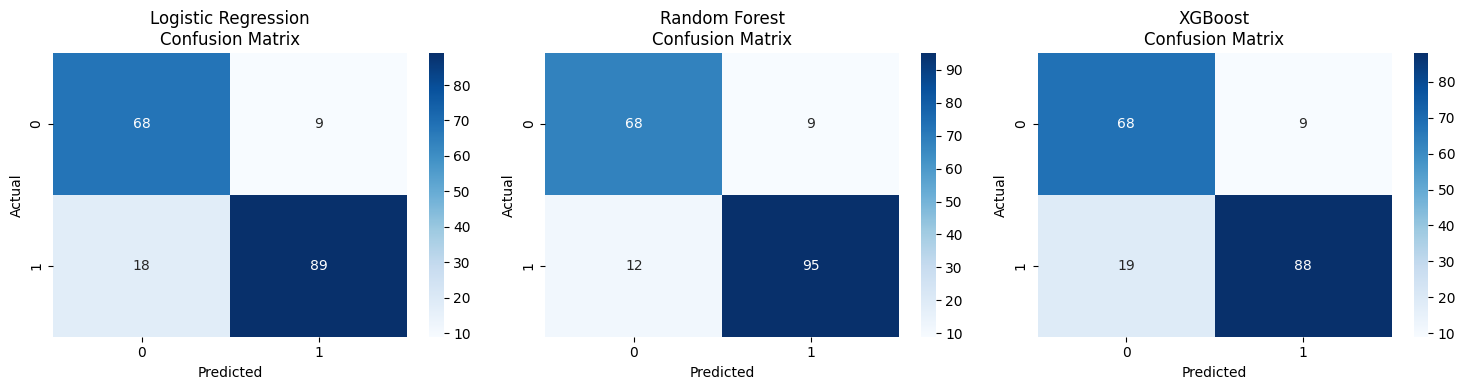

In [34]:
# Create confusion matrices for all models
plt.figure(figsize=(15, 4))

# Logistic Regression
plt.subplot(1, 3, 1)
cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression\nConfusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

# Random Forest
plt.subplot(1, 3, 2)
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest\nConfusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

# XGBoost
plt.subplot(1, 3, 3)
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues')
plt.title('XGBoost\nConfusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

plt.tight_layout()
plt.show()

**Analysis:**  
The confusion matrices show how each model distributes its errors. Random Forest correctly identifies 95 out of 107 diseased patients (best recall), while Logistic Regression and XGBoost both identify 89 and 88 respectively. All three models show similar performance on healthy patients, correctly identifying 68 out of 77. Random Forest's advantage comes from fewer false negatives (12 vs 18-19), meaning it misses fewer diseased patients.